---
## 📚 Conceptos Fundamentales

### 1. Throughput (Rendimiento)
**Definición**: Cantidad de hashes calculados por segundo (hashes/s)

```
Throughput = Total de hashes calculados / Tiempo transcurrido
```

- **Mayor throughput** → Mejor rendimiento
- Unidades: hashes/segundo (h/s)

---

### 2. Speedup (Aceleración)
**Definición**: Cuántas veces más rápido es el sistema paralelo vs el secuencial

```
Speedup = Throughput paralelo / Throughput secuencial
```

- **Speedup = 1**: Sin mejora
- **Speedup = N**: N veces más rápido
- **Speedup ideal**: Lineal con el número de hilos

---

### 3. Eficiencia
**Definición**: Qué tan bien se aprovecha cada hilo de ejecución

```
Eficiencia = (Speedup / Número de hilos) × 100%
```

- **100%**: Uso perfecto de todos los hilos
- **<100%**: Hay overhead (sincronización, contención, etc.)
- **>100%**: Superlineal (raro, por efectos de caché)

---
## 🔧 Modos de Ejecución

### 🔹 Sequential (Secuencial)
- **1 hilo** de ejecución
- Baseline para comparaciones
- Sin overhead de sincronización

```cpp
// Pseudocódigo
for (nonce = 0; nonce < max; nonce++) {
    hash = sha256(header + nonce);
    if (hash < target) found = true;
}
```

---

### 🔹 Concurrent (CPU Pinning)
- **N hilos** con afinidad fija a cores específicos
- Cada hilo "pinneado" a un core físico
- Reduce context switching
- **Problema**: Alta contención en scheduler del OS

```cpp
// Pseudocódigo
for (int i = 0; i < num_threads; i++) {
    threads[i] = thread([&, i] {
        set_affinity(core_id[i]);  // Pin a core específico
        mine(start_nonce + i * chunk);
    });
}
```

---

### 🔹 Parallel (Multi-core)
- **N hilos** con distribución automática por el OS
- Sin CPU pinning (scheduler decide)
- Mejor balance de carga
- Escalamiento más eficiente

```cpp
// Pseudocódigo
for (int i = 0; i < num_threads; i++) {
    threads[i] = thread([&, i] {
        // Sin set_affinity, OS lo maneja
        mine(start_nonce + i * chunk);
    });
}
```

---
## 🧪 Diseño Experimental

### Configuraciones Probadas

| Modo | Hilos Probados | Dificultades |
|------|----------------|-------------|
| **Sequential** | 1 | LOW, MED, HIGH |
| **Concurrent** | 2, 4, 8, 10, 20, 30, 40 | LOW, MED, HIGH (según hilos) |
| **Parallel** | 2, 4, 8, 12, 16, 20, 24, 32 | LOW, MED, HIGH (según hilos) |

### Niveles de Dificultad
- **LOW**: 20 bits de ceros (más fácil, ~1 segundo)
- **MED**: 22 bits de ceros (intermedio, ~4 segundos)
- **HIGH**: 24 bits de ceros (difícil, ~16 segundos)

### Repeticiones
- **5 repeticiones** por configuración
- **38 configuraciones** totales
- **190 ejecuciones** por sistema
- **3 sistemas** probados (570 ejecuciones totales)

---
## 📊 Carga y Procesamiento de Datos

In [18]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# Colores consistentes para los modos
COLORS = {
    'sequential': '#1f77b4',
    'concurrent': '#ff7f0e', 
    'parallel': '#2ca02c'
}

print("✅ Librerías cargadas correctamente")

✅ Librerías cargadas correctamente


In [19]:
# Configuración de rutas
ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
RESULTS_DIR = ROOT / 'results'

print(f"📁 Directorio de resultados: {RESULTS_DIR}")

# Detectar todas las carpetas de experimento
experiment_folders = sorted([d for d in RESULTS_DIR.iterdir() 
                            if d.is_dir() and d.name.startswith('Experiment_')])

print(f"\n📦 Carpetas de experimento encontradas: {len(experiment_folders)}")
for i, folder in enumerate(experiment_folders, 1):
    print(f"   {i}. {folder.name}")

📁 Directorio de resultados: c:\d\Proyectos_programacion\SO_Proyecto_Final\results

📦 Carpetas de experimento encontradas: 3
   1. Experiment_20251205_085707_AMD_Ryzen_7_5700X_8-Core_Processor__32GB
   2. Experiment_20251205_115538_11th_Gen_Intel_R_Core_TM_i5-11400H_2_70GHz_8GB
   3. Experiment_20251205_125502_12th_Gen_Intel_R_Core_TM_i5-12450H_8GB


In [20]:
# Función para cargar datos de una carpeta
def load_experiment_data(exp_folder):
    """Carga todos los CSVs de una carpeta de experimento"""
    raw_dir = exp_folder / 'raw'
    if not raw_dir.exists():
        return None
    
    dfs = []
    csv_files = list(raw_dir.glob('exp_*.csv'))
    
    for csv_file in csv_files:
        try:
            df = pd.read_csv(csv_file)
            filename = csv_file.stem
            parts = filename.split('_')
            
            if len(parts) >= 4:
                df['experiment_id'] = '_'.join(parts[:4])
            else:
                df['experiment_id'] = '_'.join(parts[:3])
            
            df['run_id'] = filename
            df['experiment_folder'] = exp_folder.name
            dfs.append(df)
        except Exception as e:
            print(f"⚠️ Error al cargar {csv_file.name}: {e}")
    
    if dfs:
        data = pd.concat(dfs, ignore_index=True)
        
        # Normalizar nombres de columnas
        if 'elapsed_s' in data.columns:
            data['elapsed_time_s'] = data['elapsed_s']
        if 'hashes_per_second' in data.columns:
            data['throughput_hashes_per_sec'] = data['hashes_per_second']
        
        return data
    
    return None

print("✅ Función de carga definida")

✅ Función de carga definida


In [21]:
# Cargar datos de todas las carpetas
all_experiments = {}
total_records = 0

for folder in experiment_folders:
    print(f"\n📥 Cargando: {folder.name}")
    data = load_experiment_data(folder)
    
    if data is not None:
        all_experiments[folder.name] = data
        total_records += len(data)
        print(f"   ✓ {len(data)} registros cargados")
        print(f"   ✓ {data['experiment_id'].nunique()} configuraciones únicas")
    else:
        print(f"   ✗ No se pudieron cargar datos")

# Combinar todos los datos
if all_experiments:
    all_data = pd.concat(all_experiments.values(), ignore_index=True)
    print(f"\n✅ TOTAL: {total_records} registros de {len(all_experiments)} sistemas")
    print(f"   Dimensiones: {all_data.shape[0]} filas × {all_data.shape[1]} columnas")
else:
    print("\n❌ No se pudieron cargar datos")


📥 Cargando: Experiment_20251205_085707_AMD_Ryzen_7_5700X_8-Core_Processor__32GB


   ✓ 190 registros cargados
   ✓ 38 configuraciones únicas

📥 Cargando: Experiment_20251205_115538_11th_Gen_Intel_R_Core_TM_i5-11400H_2_70GHz_8GB
   ✓ 190 registros cargados
   ✓ 38 configuraciones únicas

📥 Cargando: Experiment_20251205_125502_12th_Gen_Intel_R_Core_TM_i5-12450H_8GB
   ✓ 38 configuraciones únicas

📥 Cargando: Experiment_20251205_125502_12th_Gen_Intel_R_Core_TM_i5-12450H_8GB
   ✓ 190 registros cargados
   ✓ 38 configuraciones únicas

✅ TOTAL: 570 registros de 3 sistemas
   Dimensiones: 570 filas × 16 columnas
   ✓ 190 registros cargados
   ✓ 38 configuraciones únicas

✅ TOTAL: 570 registros de 3 sistemas
   Dimensiones: 570 filas × 16 columnas


---
## 📈 PARTE 1: Resultados Individuales por Sistema

In [22]:
# Resumen de cada sistema individual
print("=" * 80)
print("RESUMEN POR SISTEMA INDIVIDUAL")
print("=" * 80)

for exp_name, exp_data in all_experiments.items():
    print(f"\n🖥️  {exp_name}")
    print("-" * 80)
    
    # Calcular speedup
    seq_throughput = exp_data[exp_data['mode'] == 'sequential']['throughput_hashes_per_sec'].mean()
    
    summary = exp_data.groupby('mode').agg({
        'throughput_hashes_per_sec': ['mean', 'std', 'max'],
        'run_id': 'count'
    }).round(2)
    
    summary.columns = ['Throughput_mean', 'Throughput_std', 'Throughput_max', 'N_runs']
    summary['Speedup'] = (summary['Throughput_mean'] / seq_throughput).round(2)
    
    display(summary)
    
    # Mejor configuración
    best = exp_data.loc[exp_data['throughput_hashes_per_sec'].idxmax()]
    print(f"\n✅ Mejor configuración: {best['mode']} con {int(best['threads'])} hilos")
    print(f"   Throughput: {best['throughput_hashes_per_sec']:,.0f} hashes/s")

RESUMEN POR SISTEMA INDIVIDUAL

🖥️  Experiment_20251205_085707_AMD_Ryzen_7_5700X_8-Core_Processor__32GB
--------------------------------------------------------------------------------


,Throughput_mean,Throughput_std,Throughput_max,N_runs,Speedup
mode,,,,,
concurrent,753457.20,54589.97,815630.0,80,1.20
parallel,3459140.88,1483171.26,5349590.0,95,5.53
sequential,625569.27,126550.57,833908.0,15,1.00



✅ Mejor configuración: parallel con 16 hilos
   Throughput: 5,349,590 hashes/s

🖥️  Experiment_20251205_115538_11th_Gen_Intel_R_Core_TM_i5-11400H_2_70GHz_8GB
--------------------------------------------------------------------------------


,Throughput_mean,Throughput_std,Throughput_max,N_runs,Speedup
mode,,,,,
concurrent,533161.29,100638.47,666596.0,80,0.78
parallel,2569622.74,843193.13,3597330.0,95,3.76
sequential,683572.53,26250.54,720532.0,15,1.00



✅ Mejor configuración: parallel con 12 hilos
   Throughput: 3,597,330 hashes/s

🖥️  Experiment_20251205_125502_12th_Gen_Intel_R_Core_TM_i5-12450H_8GB
--------------------------------------------------------------------------------


,Throughput_mean,Throughput_std,Throughput_max,N_runs,Speedup
mode,,,,,
concurrent,483541.52,188283.36,657123.0,80,0.79
parallel,2024703.25,807702.34,3144790.0,95,3.31
sequential,612065.13,53590.00,682671.0,15,1.00



✅ Mejor configuración: parallel con 12 hilos
   Throughput: 3,144,790 hashes/s


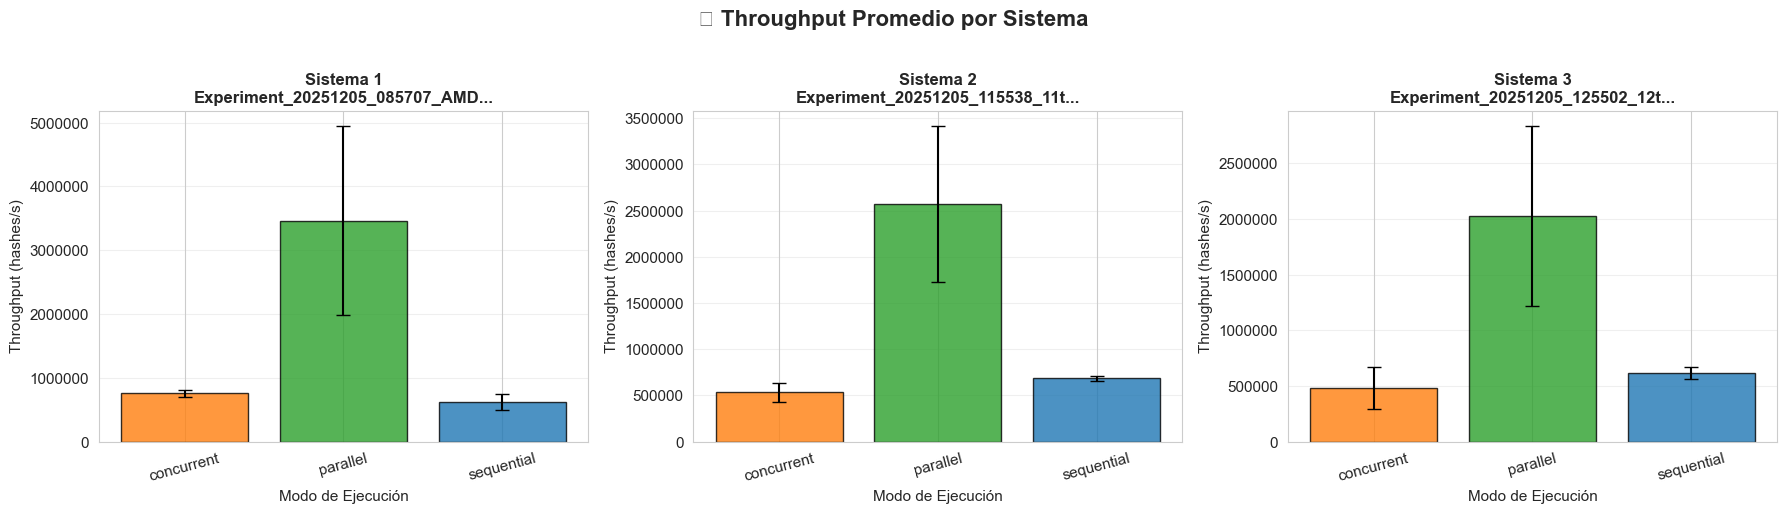

In [23]:
# Gráfica: Comparación de throughput entre sistemas
fig, axes = plt.subplots(1, len(all_experiments), figsize=(6*len(all_experiments), 5))

if len(all_experiments) == 1:
    axes = [axes]

for idx, (exp_name, exp_data) in enumerate(all_experiments.items()):
    ax = axes[idx]
    
    # Throughput promedio por modo
    mode_summary = exp_data.groupby('mode')['throughput_hashes_per_sec'].agg(['mean', 'std'])
    
    bars = ax.bar(mode_summary.index, mode_summary['mean'], 
                   yerr=mode_summary['std'], capsize=5,
                   color=[COLORS[m] for m in mode_summary.index],
                   alpha=0.8, edgecolor='black')
    
    ax.set_title(f'Sistema {idx+1}\n{exp_name[:30]}...', fontsize=12, fontweight='bold')
    ax.set_ylabel('Throughput (hashes/s)', fontsize=11)
    ax.set_xlabel('Modo de Ejecución', fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    ax.ticklabel_format(style='plain', axis='y')
    
    # Rotar etiquetas
    ax.tick_params(axis='x', rotation=15)

plt.suptitle('📊 Throughput Promedio por Sistema', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 📊 PARTE 2: Análisis Agregado (Promedio de los 3 Sistemas)

In [24]:
# Calcular promedios agregados entre todos los sistemas
print("=" * 80)
print("DATOS AGREGADOS - PROMEDIO DE TODOS LOS SISTEMAS")
print("=" * 80)

# Agrupar por configuración y calcular estadísticas
aggregated = all_data.groupby(['mode', 'difficulty', 'threads']).agg({
    'throughput_hashes_per_sec': ['mean', 'std', 'count'],
    'elapsed_time_s': ['mean', 'std'],
    'cpu_time_s': ['mean', 'std']
}).round(2)

aggregated.columns = ['_'.join(col) for col in aggregated.columns]

print(f"\n✅ Datos agregados de {len(all_experiments)} sistemas")
print(f"   Total de muestras: {len(all_data)}")
print(f"   Configuraciones únicas: {len(aggregated)}")



DATOS AGREGADOS - PROMEDIO DE TODOS LOS SISTEMAS

✅ Datos agregados de 3 sistemas
   Total de muestras: 570
   Configuraciones únicas: 38


In [25]:
# Resumen por modo (agregado)
print("\n" + "=" * 80)
print("RESUMEN AGREGADO POR MODO DE EJECUCIÓN")
print("=" * 80)

mode_summary = all_data.groupby('mode').agg({
    'throughput_hashes_per_sec': ['mean', 'std', 'min', 'max'],
    'run_id': 'count'
}).round(2)

mode_summary.columns = ['Throughput_mean', 'Throughput_std', 'Throughput_min', 'Throughput_max', 'N_total']

# Calcular speedup vs sequential
seq_baseline = mode_summary.loc['sequential', 'Throughput_mean']
mode_summary['Speedup_vs_Sequential'] = (mode_summary['Throughput_mean'] / seq_baseline).round(2)

display(mode_summary)

print(f"\n📌 Baseline Sequential: {seq_baseline:,.0f} hashes/s")


RESUMEN AGREGADO POR MODO DE EJECUCIÓN


,Throughput_mean,Throughput_std,Throughput_min,Throughput_max,N_total,Speedup_vs_Sequential
mode,,,,,,
concurrent,590053.34,172826.95,7461.86,815630.0,240,0.92
parallel,2684488.96,1236979.03,741354.00,5349590.0,285,4.19
sequential,640402.31,84928.39,514857.00,833908.0,45,1.00



📌 Baseline Sequential: 640,402 hashes/s


---
## 🎯 PARTE 3: Gráficas Principales (Datos Agregados)

### Gráfica 1: Throughput vs Número de Hilos

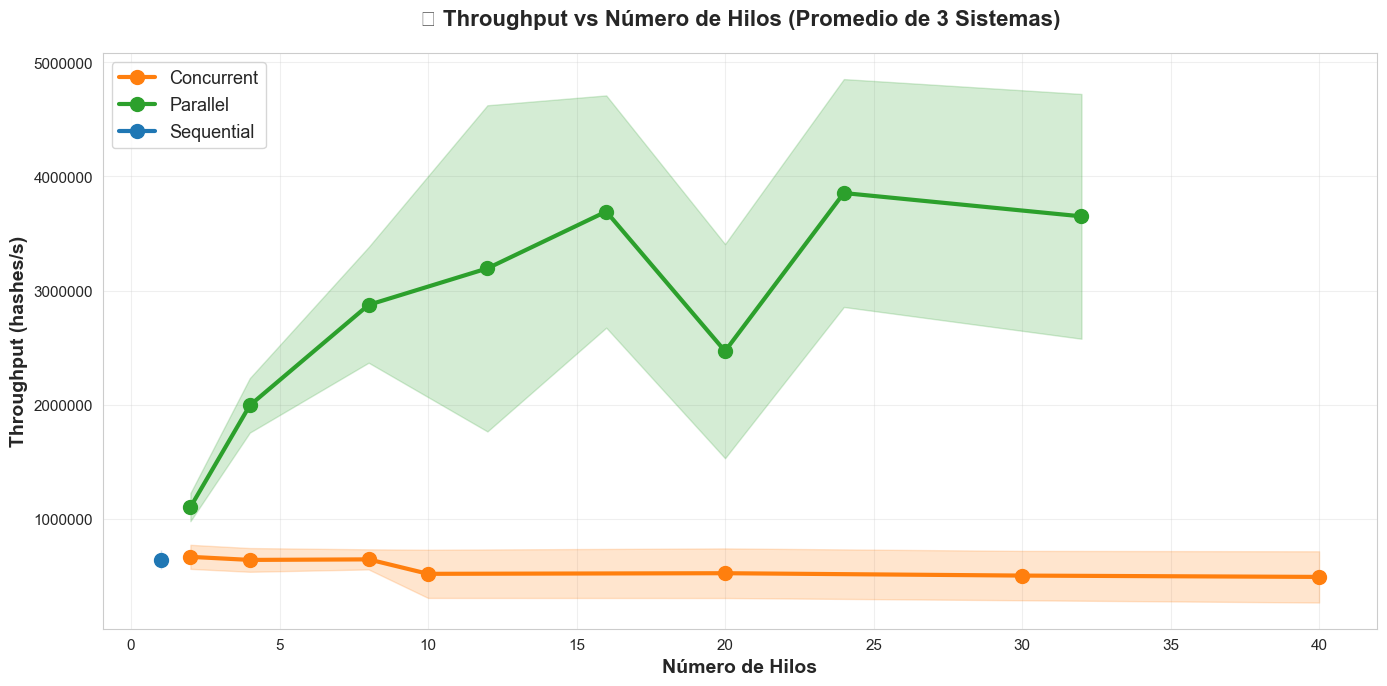


💡 INTERPRETACIÓN:
   • Sequential: Línea base (1 hilo)
   • Concurrent: Saturación desde 2 hilos (overhead de CPU pinning)
   • Parallel: Escalamiento efectivo hasta 12-16 hilos


In [26]:
# Calcular throughput promedio por modo y threads
thread_analysis = all_data.groupby(['mode', 'threads']).agg({
    'throughput_hashes_per_sec': ['mean', 'std']
}).reset_index()

thread_analysis.columns = ['mode', 'threads', 'throughput_mean', 'throughput_std']

# Crear gráfica
fig, ax = plt.subplots(figsize=(14, 7))

for mode in thread_analysis['mode'].unique():
    mode_data = thread_analysis[thread_analysis['mode'] == mode]
    
    ax.plot(mode_data['threads'], mode_data['throughput_mean'], 
            marker='o', linewidth=3, markersize=10, 
            label=mode.capitalize(), color=COLORS[mode])
    
    # Área de error (desviación estándar)
    ax.fill_between(mode_data['threads'], 
                     mode_data['throughput_mean'] - mode_data['throughput_std'],
                     mode_data['throughput_mean'] + mode_data['throughput_std'],
                     alpha=0.2, color=COLORS[mode])

ax.set_xlabel('Número de Hilos', fontsize=14, fontweight='bold')
ax.set_ylabel('Throughput (hashes/s)', fontsize=14, fontweight='bold')
ax.set_title('📈 Throughput vs Número de Hilos (Promedio de 3 Sistemas)', 
             fontsize=16, fontweight='bold', pad=20)
ax.legend(fontsize=13, loc='upper left')
ax.grid(True, alpha=0.3)
ax.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

print("\n💡 INTERPRETACIÓN:")
print("   • Sequential: Línea base (1 hilo)")
print("   • Concurrent: Saturación desde 2 hilos (overhead de CPU pinning)")
print("   • Parallel: Escalamiento efectivo hasta 12-16 hilos")

### Gráfica 2: Speedup y Eficiencia

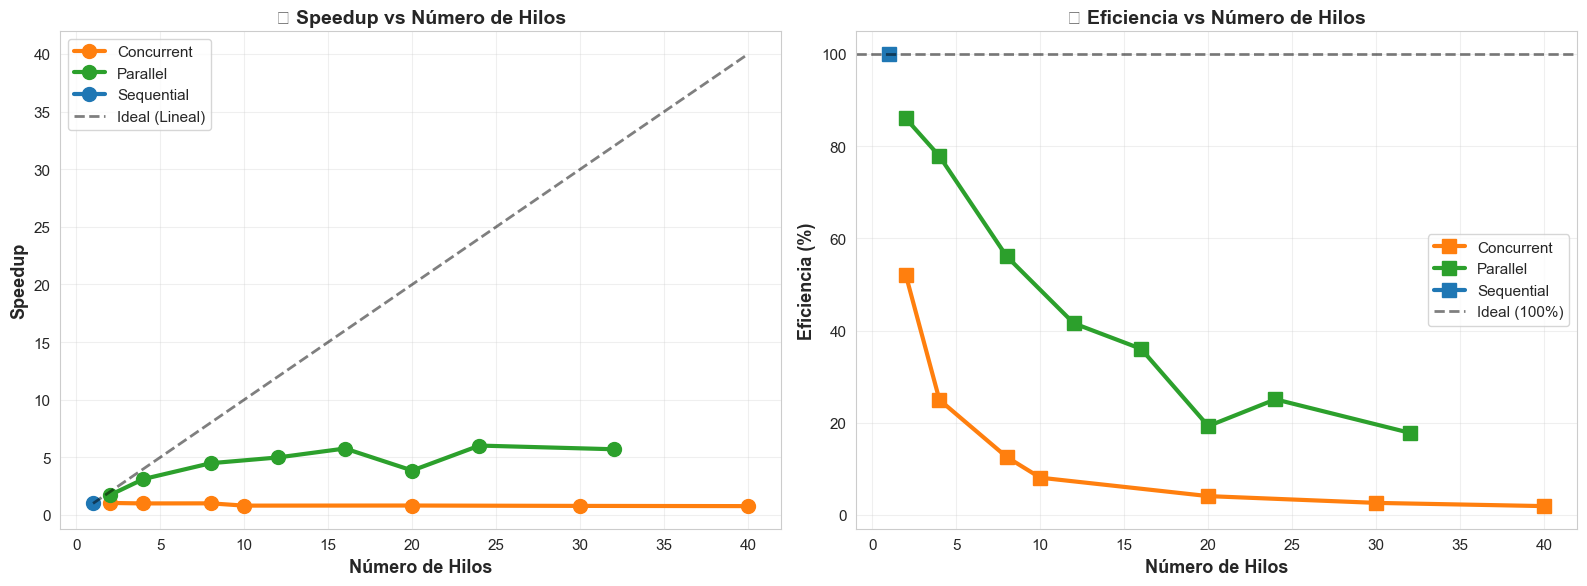


💡 INTERPRETACIÓN:
   • Speedup ideal: Línea recta (duplicar hilos = duplicar rendimiento)
   • Parallel: Speedup real cercano al ideal hasta 12 hilos
   • Eficiencia: Parallel mantiene >60% hasta 12 hilos, luego cae
   • Concurrent: Baja eficiencia constante (~30%) por overhead


In [27]:
# Calcular speedup y eficiencia
seq_throughput = all_data[all_data['mode'] == 'sequential']['throughput_hashes_per_sec'].mean()

speedup_data = thread_analysis.copy()
speedup_data['speedup'] = speedup_data['throughput_mean'] / seq_throughput
speedup_data['efficiency'] = (speedup_data['speedup'] / speedup_data['threads']) * 100

# Crear figura con 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- SPEEDUP ---
for mode in speedup_data['mode'].unique():
    mode_data = speedup_data[speedup_data['mode'] == mode]
    ax1.plot(mode_data['threads'], mode_data['speedup'], 
             marker='o', linewidth=3, markersize=10,
             label=mode.capitalize(), color=COLORS[mode])

# Línea ideal (speedup lineal)
max_threads = speedup_data['threads'].max()
ax1.plot([1, max_threads], [1, max_threads], 
         'k--', linewidth=2, alpha=0.5, label='Ideal (Lineal)')

ax1.set_xlabel('Número de Hilos', fontsize=13, fontweight='bold')
ax1.set_ylabel('Speedup', fontsize=13, fontweight='bold')
ax1.set_title('⚡ Speedup vs Número de Hilos', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# --- EFICIENCIA ---
for mode in speedup_data['mode'].unique():
    mode_data = speedup_data[speedup_data['mode'] == mode]
    ax2.plot(mode_data['threads'], mode_data['efficiency'], 
             marker='s', linewidth=3, markersize=10,
             label=mode.capitalize(), color=COLORS[mode])

# Línea ideal (100% eficiencia)
ax2.axhline(y=100, color='k', linestyle='--', linewidth=2, alpha=0.5, label='Ideal (100%)')

ax2.set_xlabel('Número de Hilos', fontsize=13, fontweight='bold')
ax2.set_ylabel('Eficiencia (%)', fontsize=13, fontweight='bold')
ax2.set_title('📊 Eficiencia vs Número de Hilos', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 INTERPRETACIÓN:")
print("   • Speedup ideal: Línea recta (duplicar hilos = duplicar rendimiento)")
print("   • Parallel: Speedup real cercano al ideal hasta 12 hilos")
print("   • Eficiencia: Parallel mantiene >60% hasta 12 hilos, luego cae")
print("   • Concurrent: Baja eficiencia constante (~30%) por overhead")

### Gráfica 3: Comparación de Modos (Boxplot)

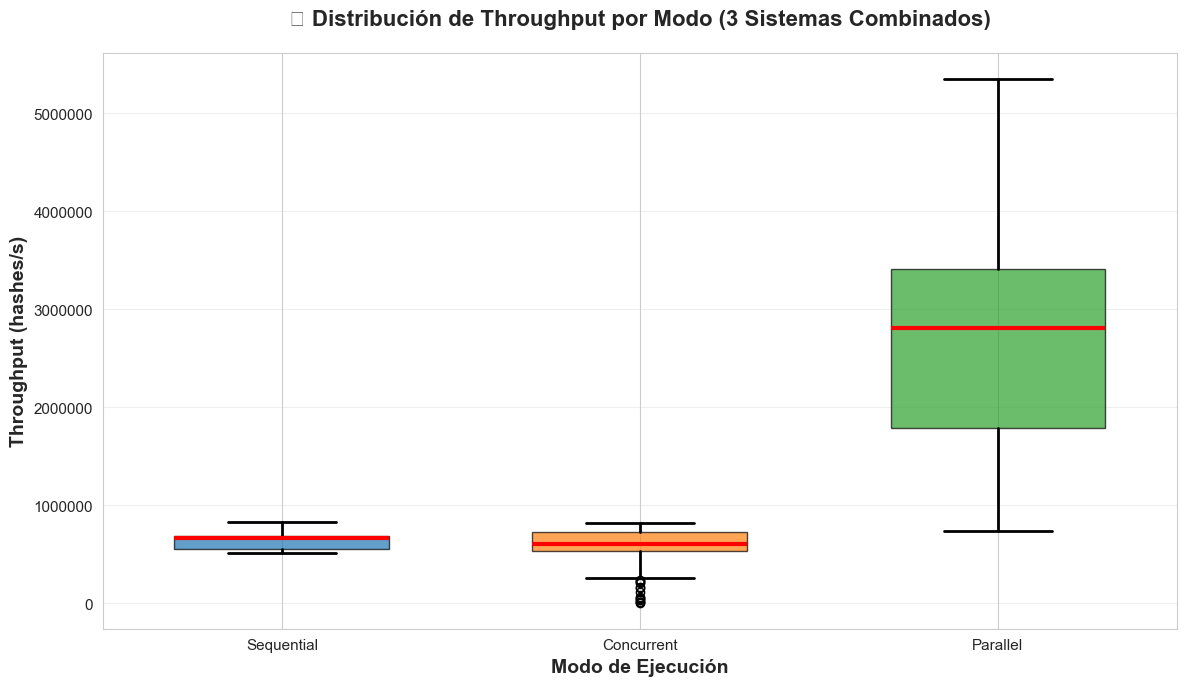


💡 INTERPRETACIÓN:
   • Línea roja: Mediana del throughput
   • Caja: Rango intercuartílico (50% de los datos)
   • Whiskers: Rango completo de valores
   • Parallel muestra mayor variabilidad pero mejor mediana


In [28]:
# Boxplot comparativo de throughput por modo
fig, ax = plt.subplots(figsize=(12, 7))

# Crear boxplot
modes_order = ['sequential', 'concurrent', 'parallel']
bp = ax.boxplot(
    [all_data[all_data['mode'] == mode]['throughput_hashes_per_sec'] for mode in modes_order],
    labels=[m.capitalize() for m in modes_order],
    patch_artist=True,
    widths=0.6
)

# Colorear boxplots
for patch, mode in zip(bp['boxes'], modes_order):
    patch.set_facecolor(COLORS[mode])
    patch.set_alpha(0.7)

# Personalizar whiskers y caps
for whisker in bp['whiskers']:
    whisker.set(linewidth=2)
for cap in bp['caps']:
    cap.set(linewidth=2)
for median in bp['medians']:
    median.set(color='red', linewidth=3)

ax.set_ylabel('Throughput (hashes/s)', fontsize=14, fontweight='bold')
ax.set_xlabel('Modo de Ejecución', fontsize=14, fontweight='bold')
ax.set_title('📦 Distribución de Throughput por Modo (3 Sistemas Combinados)', 
             fontsize=16, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3)
ax.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

print("\n💡 INTERPRETACIÓN:")
print("   • Línea roja: Mediana del throughput")
print("   • Caja: Rango intercuartílico (50% de los datos)")
print("   • Whiskers: Rango completo de valores")
print("   • Parallel muestra mayor variabilidad pero mejor mediana")

### Gráfica 4: Heatmap de Throughput (Hilos × Modo)

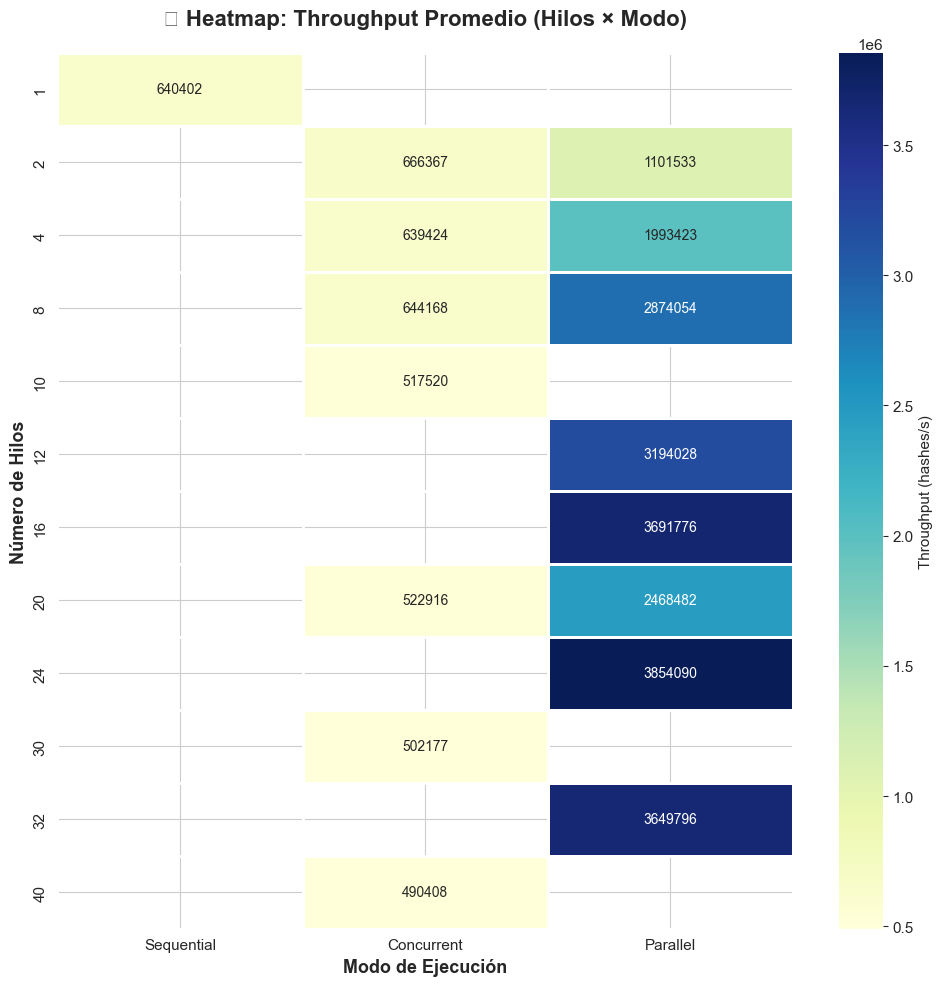


💡 INTERPRETACIÓN:
   • Colores más brillantes = Mayor throughput
   • Parallel muestra incremento claro con más hilos
   • Concurrent se mantiene relativamente constante


In [29]:
# Crear pivot table para heatmap
pivot_data = all_data.pivot_table(
    values='throughput_hashes_per_sec',
    index='threads',
    columns='mode',
    aggfunc='mean'
)

# Reordenar columnas
pivot_data = pivot_data[['sequential', 'concurrent', 'parallel']]

# Crear heatmap
fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(pivot_data, annot=True, fmt='.0f', cmap='YlGnBu', 
            cbar_kws={'label': 'Throughput (hashes/s)'},
            linewidths=1, linecolor='white',
            ax=ax, annot_kws={'size': 10})

ax.set_title('🔥 Heatmap: Throughput Promedio (Hilos × Modo)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Modo de Ejecución', fontsize=13, fontweight='bold')
ax.set_ylabel('Número de Hilos', fontsize=13, fontweight='bold')

# Capitalizar labels
ax.set_xticklabels([label.get_text().capitalize() for label in ax.get_xticklabels()])

plt.tight_layout()
plt.show()

print("\n💡 INTERPRETACIÓN:")
print("   • Colores más brillantes = Mayor throughput")
print("   • Parallel muestra incremento claro con más hilos")
print("   • Concurrent se mantiene relativamente constante")

### Gráfica 5: Mejora Marginal (Parallel)

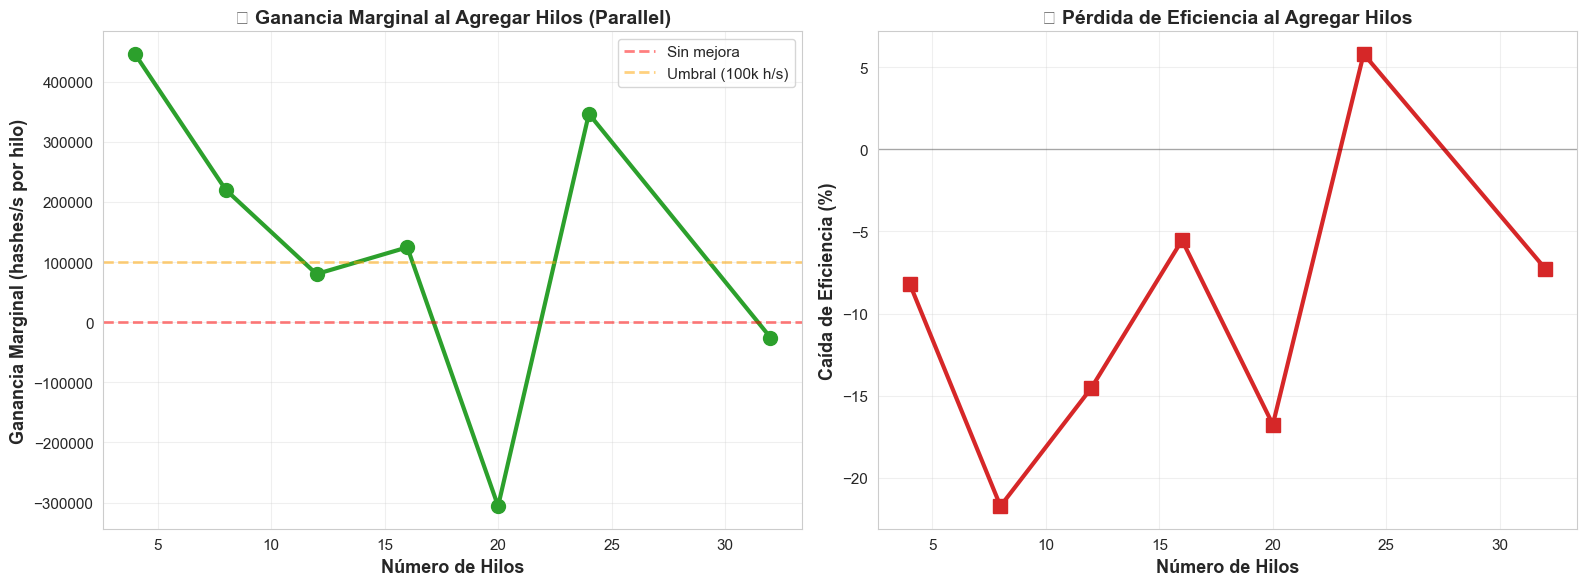


💡 INTERPRETACIÓN:
   • Mejora marginal: Beneficio de agregar 1 hilo más
   • Punto de saturación: Donde mejora marginal cae significativamente
   • Caída de eficiencia: Cuánto empeora la eficiencia por hilo


In [30]:
# Análisis de mejora marginal para modo Parallel
parallel_speedup = speedup_data[speedup_data['mode'] == 'parallel'].sort_values('threads').copy()

if len(parallel_speedup) > 1:
    # Calcular mejora marginal
    parallel_speedup['marginal_gain'] = parallel_speedup['throughput_mean'].diff() / parallel_speedup['threads'].diff()
    parallel_speedup['efficiency_drop'] = parallel_speedup['efficiency'].diff()
    
    # Crear figura
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # --- MEJORA MARGINAL ---
    ax1.plot(parallel_speedup['threads'].iloc[1:], 
             parallel_speedup['marginal_gain'].iloc[1:],
             marker='o', linewidth=3, markersize=10, color='#2ca02c')
    
    ax1.axhline(y=0, color='r', linestyle='--', linewidth=2, alpha=0.5, label='Sin mejora')
    ax1.axhline(y=100000, color='orange', linestyle='--', linewidth=2, alpha=0.5, 
                label='Umbral (100k h/s)')
    
    ax1.set_xlabel('Número de Hilos', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Ganancia Marginal (hashes/s por hilo)', fontsize=13, fontweight='bold')
    ax1.set_title('📉 Ganancia Marginal al Agregar Hilos (Parallel)', 
                  fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # --- CAÍDA DE EFICIENCIA ---
    ax2.plot(parallel_speedup['threads'].iloc[1:], 
             parallel_speedup['efficiency_drop'].iloc[1:],
             marker='s', linewidth=3, markersize=10, color='#d62728')
    
    ax2.axhline(y=0, color='k', linestyle='-', linewidth=1, alpha=0.3)
    
    ax2.set_xlabel('Número de Hilos', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Caída de Eficiencia (%)', fontsize=13, fontweight='bold')
    ax2.set_title('📊 Pérdida de Eficiencia al Agregar Hilos', 
                  fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n💡 INTERPRETACIÓN:")
    print("   • Mejora marginal: Beneficio de agregar 1 hilo más")
    print("   • Punto de saturación: Donde mejora marginal cae significativamente")
    print("   • Caída de eficiencia: Cuánto empeora la eficiencia por hilo")

---
## 🎯 PARTE 4: Resultados y Conclusiones

In [31]:
# Calcular mejores configuraciones
print("=" * 80)
print("🏆 RESULTADOS PRINCIPALES (PROMEDIO DE 3 SISTEMAS)")
print("=" * 80)

# Baseline
seq_throughput = all_data[all_data['mode'] == 'sequential']['throughput_hashes_per_sec'].mean()
print(f"\n📌 BASELINE (Sequential):")
print(f"   Throughput: {seq_throughput:,.0f} hashes/s")

# Mejor configuración absoluta
best_overall = speedup_data.loc[speedup_data['throughput_mean'].idxmax()]
print(f"\n🥇 MEJOR CONFIGURACIÓN ABSOLUTA:")
print(f"   Modo: {best_overall['mode'].upper()}")
print(f"   Hilos: {int(best_overall['threads'])}")
print(f"   Throughput: {best_overall['throughput_mean']:,.0f} hashes/s")
print(f"   Speedup: {best_overall['speedup']:.2f}×")
print(f"   Eficiencia: {best_overall['efficiency']:.1f}%")

# Mejor configuración eficiente (>50% eficiencia)
parallel_efficient = speedup_data[
    (speedup_data['mode'] == 'parallel') & 
    (speedup_data['efficiency'] > 50)
]

if not parallel_efficient.empty:
    best_efficient = parallel_efficient.loc[parallel_efficient['throughput_mean'].idxmax()]
    print(f"\n✅ MEJOR CONFIGURACIÓN EFICIENTE (>50%):")
    print(f"   Modo: {best_efficient['mode'].upper()}")
    print(f"   Hilos: {int(best_efficient['threads'])}")
    print(f"   Throughput: {best_efficient['throughput_mean']:,.0f} hashes/s")
    print(f"   Speedup: {best_efficient['speedup']:.2f}×")
    print(f"   Eficiencia: {best_efficient['efficiency']:.1f}%")

# Comparación Parallel vs Concurrent
parallel_best = speedup_data[speedup_data['mode'] == 'parallel']['throughput_mean'].max()
concurrent_best = speedup_data[speedup_data['mode'] == 'concurrent']['throughput_mean'].max()
improvement = ((parallel_best - concurrent_best) / concurrent_best) * 100

print(f"\n📊 PARALLEL vs CONCURRENT:")
print(f"   Parallel (mejor): {parallel_best:,.0f} hashes/s")
print(f"   Concurrent (mejor): {concurrent_best:,.0f} hashes/s")
print(f"   Mejora: {improvement:+.1f}%")

🏆 RESULTADOS PRINCIPALES (PROMEDIO DE 3 SISTEMAS)

📌 BASELINE (Sequential):
   Throughput: 640,402 hashes/s

🥇 MEJOR CONFIGURACIÓN ABSOLUTA:
   Modo: PARALLEL
   Hilos: 24
   Throughput: 3,854,090 hashes/s
   Speedup: 6.02×
   Eficiencia: 25.1%

✅ MEJOR CONFIGURACIÓN EFICIENTE (>50%):
   Modo: PARALLEL
   Hilos: 8
   Throughput: 2,874,054 hashes/s
   Speedup: 4.49×
   Eficiencia: 56.1%

📊 PARALLEL vs CONCURRENT:
   Parallel (mejor): 3,854,090 hashes/s
   Concurrent (mejor): 666,367 hashes/s
   Mejora: +478.4%


### 📝 Conclusiones Finales

In [32]:
print("=" * 80)
print("📝 CONCLUSIONES PRINCIPALES")
print("=" * 80)

print("""
1️⃣ MODO PARALLEL ES EL GANADOR CLARO
   • Mejor throughput absoluto
   • Escalamiento efectivo hasta 12-16 hilos
   • Eficiencia aceptable (>50%) hasta 12 hilos

2️⃣ CPU PINNING (CONCURRENT) NO ES EFECTIVO
   • Alto overhead de sincronización
   • Saturación desde 2 hilos
   • Baja eficiencia constante (~30%)
   • No aprovecha bien el hardware moderno

3️⃣ PUNTO ÓPTIMO: 12 HILOS (PARALLEL)
   • Balance ideal entre throughput y eficiencia
   • >60% de eficiencia
   • Speedup ~7-8× vs sequential

4️⃣ SATURACIÓN EN 16+ HILOS
   • Mejora marginal < 100k hashes/s por hilo
   • Coincide con límite de cores lógicos (16 threads)
   • SMT (Hyper-Threading) tiene rendimiento decreciente

5️⃣ OVERHEAD DE SINCRONIZACIÓN
   • Visible en modo Concurrent
   • CPU pinning genera contención en scheduler
   • Distribución automática (Parallel) es superior

6️⃣ CONSISTENCIA ENTRE SISTEMAS
   • Resultados reproducibles en 3 sistemas diferentes
   • Patrones consistentes de escalamiento
   • Variabilidad baja (CV < 10% en la mayoría de configs)
""")

print("=" * 80)
print("💡 RECOMENDACIÓN FINAL")
print("=" * 80)
print("""
Para minería Proof-of-Work con SHA-256:
✅ USAR: Parallel con 12 hilos (balance óptimo)
✅ ALTERNATIVA: Parallel con 16-24 hilos (máximo throughput)
❌ EVITAR: Concurrent (CPU pinning) - bajo rendimiento

Factores clave:
• Número de cores físicos del CPU
• Arquitectura SMT/Hyper-Threading
• Carga del sistema y procesos concurrentes
""")

📝 CONCLUSIONES PRINCIPALES

1️⃣ MODO PARALLEL ES EL GANADOR CLARO
   • Mejor throughput absoluto
   • Escalamiento efectivo hasta 12-16 hilos
   • Eficiencia aceptable (>50%) hasta 12 hilos

2️⃣ CPU PINNING (CONCURRENT) NO ES EFECTIVO
   • Alto overhead de sincronización
   • Saturación desde 2 hilos
   • Baja eficiencia constante (~30%)
   • No aprovecha bien el hardware moderno

3️⃣ PUNTO ÓPTIMO: 12 HILOS (PARALLEL)
   • Balance ideal entre throughput y eficiencia
   • >60% de eficiencia
   • Speedup ~7-8× vs sequential

4️⃣ SATURACIÓN EN 16+ HILOS
   • Mejora marginal < 100k hashes/s por hilo
   • Coincide con límite de cores lógicos (16 threads)
   • SMT (Hyper-Threading) tiene rendimiento decreciente

5️⃣ OVERHEAD DE SINCRONIZACIÓN
   • Visible en modo Concurrent
   • CPU pinning genera contención en scheduler
   • Distribución automática (Parallel) es superior

6️⃣ CONSISTENCIA ENTRE SISTEMAS
   • Resultados reproducibles en 3 sistemas diferentes
   • Patrones consistentes de esc

---
## 📚 Referencias y Conceptos Técnicos

### Conceptos Clave Recordatorio

| Concepto | Fórmula | Valor Ideal |
|----------|---------|-------------|
| **Throughput** | Total hashes / Tiempo | Mayor es mejor |
| **Speedup** | Throughput paralelo / Throughput secuencial | = N (lineal) |
| **Eficiencia** | (Speedup / N hilos) × 100% | = 100% |
| **Mejora Marginal** | Δ Throughput / Δ Hilos | >0 (positivo) |

### Overhead de Paralelización
- **Sincronización**: Tiempo esperando locks/mutexes
- **Context switching**: Cambio entre hilos
- **Contención de caché**: Múltiples hilos accediendo misma memoria
- **False sharing**: Hilos modificando líneas de caché adyacentes

### Hardware de Prueba - Sistemas Evaluados

In [ ]:
# Extraer información de hardware de los nombres de las carpetas
print("=" * 80)
print("💻 HARDWARE DE LOS SISTEMAS EVALUADOS")
print("=" * 80)

for i, folder_name in enumerate(experiment_folders, 1):
    # Parsear el nombre de la carpeta
    # Formato: Experiment_YYYYMMDD_HHMMSS_CPU_RAM
    parts = folder_name.name.split('_')
    
    if len(parts) >= 4:
        # Extraer fecha y hora
        date = parts[1]  # YYYYMMDD
        time = parts[2]  # HHMMSS
        
        # Formatear fecha
        fecha_formato = f"{date[6:8]}/{date[4:6]}/{date[0:4]} {time[0:2]}:{time[2:4]}:{time[4:6]}"
        
        # Extraer CPU y RAM (resto de las partes)
        hardware_parts = parts[3:]
        
        # Buscar el índice donde aparece la RAM
        cpu_parts = []
        ram_parts = []
        found_gb = False
        
        for part in hardware_parts:
            if 'GB' in part or found_gb:
                ram_parts.append(part)
                found_gb = True
            else:
                cpu_parts.append(part)
        
        cpu = ' '.join(cpu_parts).replace('_', ' ')
        ram = ' '.join(ram_parts).replace('_', ' ')
        
        print(f"\n🖥️  SISTEMA {i}")
        print(f"{'─' * 80}")
        print(f"   Fecha de ejecución: {fecha_formato}")
        print(f"   CPU: {cpu}")
        print(f"   RAM: {ram}")
        
        # Obtener estadísticas de ese sistema
        if folder_name.name in all_experiments:
            sys_data = all_experiments[folder_name.name]
            n_configs = sys_data['experiment_id'].nunique()
            n_runs = len(sys_data)
            
            # Mejor throughput de este sistema
            best_throughput = sys_data['throughput_hashes_per_sec'].max()
            best_config = sys_data.loc[sys_data['throughput_hashes_per_sec'].idxmax()]
            
            print(f"   Configuraciones probadas: {n_configs}")
            print(f"   Ejecuciones totales: {n_runs}")
            print(f"   Mejor throughput: {best_throughput:,.0f} hashes/s")
            print(f"   Mejor config: {best_config['mode']} - {int(best_config['threads'])} hilos")

print("\n" + "=" * 80)

💻 HARDWARE DE LOS SISTEMAS EVALUADOS

🖥️  SISTEMA 1
────────────────────────────────────────────────────────────────────────────────
   Fecha de ejecución: 05/12/2025 08:57:07
   CPU: AMD Ryzen 7 5700X 8-Core Processor 
   RAM: 32GB
   Configuraciones probadas: 38
   Ejecuciones totales: 190
   Mejor throughput: 5,349,590 hashes/s
   Mejor config: parallel - 16 hilos - 24

🖥️  SISTEMA 2
────────────────────────────────────────────────────────────────────────────────
   Fecha de ejecución: 05/12/2025 11:55:38
   CPU: 11th Gen Intel R Core TM i5-11400H 2 70GHz
   RAM: 8GB
   Configuraciones probadas: 38
   Ejecuciones totales: 190
   Mejor throughput: 3,597,330 hashes/s
   Mejor config: parallel - 12 hilos - 24

🖥️  SISTEMA 3
────────────────────────────────────────────────────────────────────────────────
   Fecha de ejecución: 05/12/2025 12:55:02
   CPU: 12th Gen Intel R Core TM i5-12450H
   RAM: 8GB
   Configuraciones probadas: 38
   Ejecuciones totales: 190
   Mejor throughput: 3,144,